# SET UP

In [61]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
%%R

require('tidyverse')

# Load the Data

In [64]:
%%R


df <- read_csv('cleaned_output.csv')

Rows: 11980 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): University, Department, Academic Year, Field, School
dbl (2): Overall Pay, LW Ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [65]:
%%R

df

# A tibble: 11,980 × 7
   University   Department `Overall Pay` `LW Ratio` `Academic Year` Field School
   <chr>        <chr>              <dbl>      <dbl> <chr>           <chr> <chr> 
 1 lawrence te… architect…         20000      NA    2025-2026       Huma… <NA>  
 2 Boston Univ… Bioinform…         46350       1.62 2025-2026       STEM  <NA>  
 3 North Carol… Industria…         21250      NA    2023-2024       STEM  <NA>  
 4 North Carol… Industria…         17000      NA    2022-2023       STEM  <NA>  
 5 Brown Unive… Mathemati…         52000       2.29 2025-2026       STEM  Ivy   
 6 University … City and …         20600       0.93 2025-2026       Soci… <NA>  
 7 Northwester… Communica…         45000       1.85 2024-2025       Soci… <NA>  
 8 Princeton U… Politics           49920       1.96 2024-2025       Soci… Ivy   
 9 University … Chemistry          47000       1.69 2025-2026       STEM  <NA>  
10 Georgia Ins… Chemistry          35408       1.52 2025-2026       STEM  <NA>  
# ℹ 1

# Exploratory Analysis: summary statistics

In [66]:
%%R
# filter out nonsense data

df <- df %>% filter(`Overall Pay` >= 15000, `Overall Pay` <= 90000)

## getting a statistical summary for each Field of Study

In [67]:
%%R

df %>%
    group_by(Field) %>%
    summarise(
        count = n(),
        mean = mean(`Overall Pay`, na.rm = TRUE),
        sd = sd(`Overall Pay`, na.rm = TRUE),
        min = min(`Overall Pay`, na.rm = TRUE),
        q1 = quantile(`Overall Pay`, 0.25, na.rm = TRUE),
        median = median(`Overall Pay`, na.rm = TRUE),
        q3 = quantile(`Overall Pay`, 0.75, na.rm = TRUE),
        max = max(`Overall Pay`, na.rm = TRUE)
    )


# A tibble: 4 × 9
  Field          count   mean    sd   min    q1 median    q3   max
  <chr>          <int>  <dbl> <dbl> <dbl> <dbl>  <dbl> <dbl> <dbl>
1 Business         308 30857. 8848. 15000 24575  30000 36500 68000
2 Humanities      1453 25696. 8075. 15000 19650  24000 30500 85000
3 STEM            7492 29343. 7587. 15000 24000  29000 33800 87467
4 Social Science  2727 26598. 8253. 15000 20200  25000 31000 90000


# see the distribution of stipend by discipline across a time series

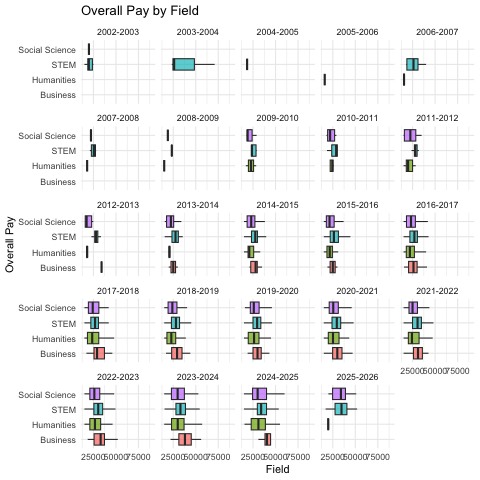

In [68]:
%%R

ggplot(df, aes(x = `Overall Pay`, y = Field, fill = Field)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.7) + 
  theme_minimal() +
  labs(title = "Overall Pay by Field",
       x = "Field", 
       y = "Overall Pay") +
    facet_wrap(~`Academic Year`) +
  theme(legend.position = "none")

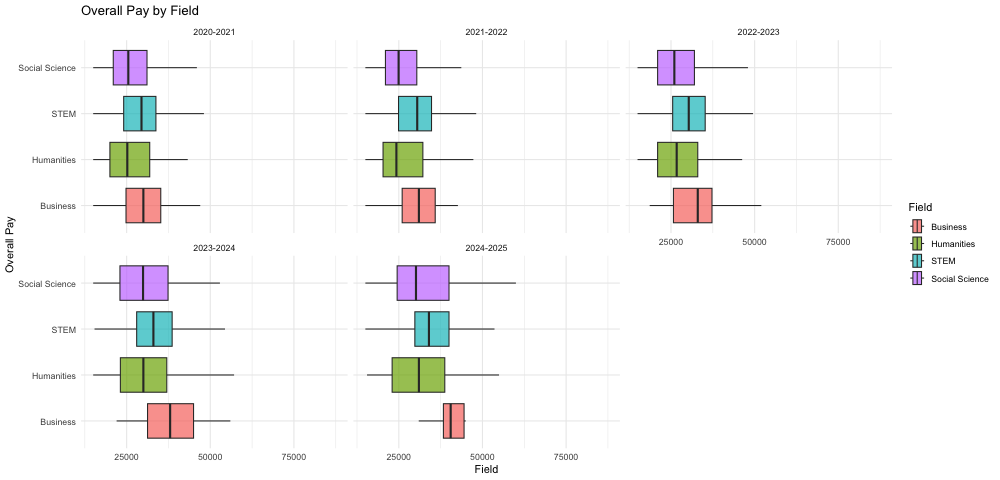

In [69]:
%%R -w 1000


df_filtered <- df[df$`Academic Year` %in% c("2020-2021", "2021-2022", "2022-2023", "2023-2024", "2024-2025"), ]


df_filtered$`Academic Year` <- factor(df_filtered$`Academic Year`, 
                                      levels = c("2020-2021", "2021-2022", "2022-2023", "2023-2024", "2024-2025"))


ggplot(df_filtered, aes(x = `Overall Pay`, y = Field, fill = Field)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.7) + 
  theme_minimal() +
  labs(title = "Overall Pay by Field",
       x = "Field", 
       y = "Overall Pay") +
  facet_wrap(~`Academic Year`) +
  theme_minimal()

In [70]:
%%R -w1000

# Adjust the 'Academic Year' factor to include years before 2020
df$`Academic Year` <- factor(df$`Academic Year`, 
                             levels = c("2015-2016", "2016-2017", "2017-2018", "2018-2019", "2019-2020", 
                                        "2020-2021", "2021-2022", "2022-2023", "2023-2024", "2024-2025"))

# Load necessary library
library(dplyr)

# Remove rows with NA in 'Academic Year' or 'Overall Pay' and calculate median
df_median <- df %>%
  filter(!is.na(`Academic Year`) & !is.na(`Overall Pay`)) %>%
  group_by(`Academic Year`, Field) %>%
  summarise(median_pay = median(`Overall Pay`, na.rm = TRUE), .groups = 'drop')



In [71]:
%%R

library(ggtext)

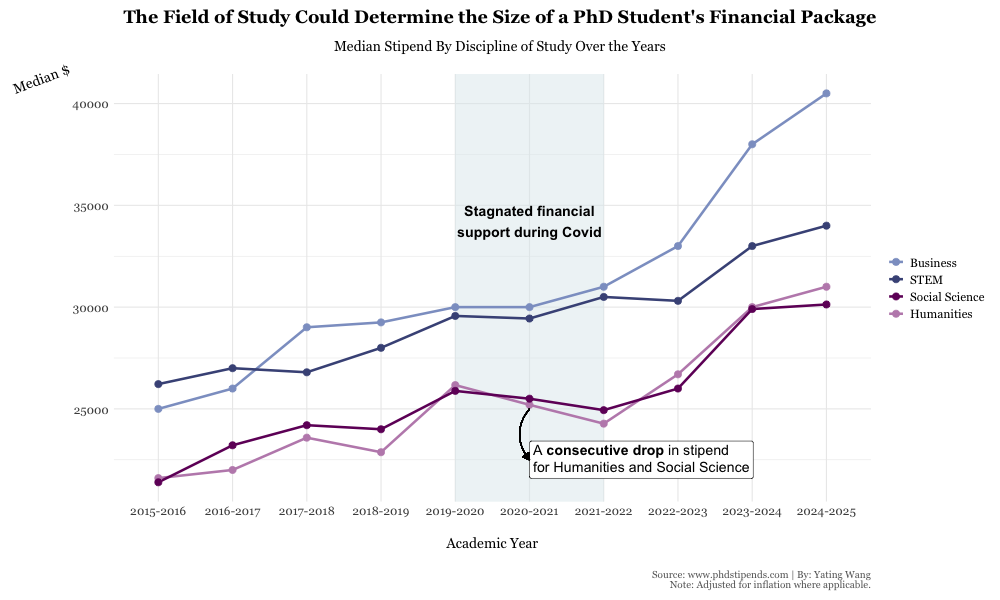

In [72]:
%%R -h 600 -w 1000

custom_colors <- c(
    "STEM" = "#485487",  
    "Humanities" = "#bf8cb9",      
    "Business" = "#8da0cb",
    "Social Science" = "#711568"
)

linechart <- ggplot(df_median, aes(x = `Academic Year`, y = median_pay, 
                      color = reorder(Field, -median_pay),  
                      group = Field)) +

  annotate("rect", xmin = "2019-2020", xmax = "2021-2022", ymin = -Inf, ymax = Inf, 
           fill = "#deeaee", alpha = 0.5) +  

  geom_line(linewidth = 1.2) +  
  geom_point(size = 3) +  

  annotate("text", x = "2020-2021", y = 35000, 
         label = "Stagnated financial\nsupport during Covid", 
         color = "black", size = 5, 
         fontface = "bold", vjust = 1) +

  annotate("richtext", x = "2020-2021", y = 22500, 
           label = "A <b>consecutive drop</b> in stipend<br>for Humanities and Social Science", 
           size = 5, color = "black", hjust = 0) + 


  geom_curve(aes(x = "2020-2021", y = 25000, xend = "2020-2021", yend = 22500), 
           arrow = arrow(length = unit(0.1, "inches"), type = "closed"), 
           color = "black", curvature = 0.4, size = 0.5) +

  theme_minimal(base_family = "Georgia") +  

  labs(
    title = "The Field of Study Could Determine the Size of a PhD Student's Financial Package",
    subtitle = "Median Stipend By Discipline of Study Over the Years",
    caption = "Source: www.phdstipends.com | By: Yating Wang\nNote: Adjusted for inflation where applicable.",
    x = "Academic Year", 
    y = "Median $"
  ) +

  theme(
    text = element_text(family = "Georgia"),  
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold", margin = margin(b = 15)),  
    plot.subtitle = element_text(size = 14, hjust = 0.5, margin = margin(b = 20)),  
    axis.title.x = element_text(size = 14, margin = margin(t = 20)),  
    axis.title.y = element_text(size = 14, angle = 20),
    axis.text = element_text(size = 12),  
    legend.title = element_blank(),  
    legend.text = element_text(size = 12),  
    legend.position = "right",  
    plot.caption = element_text(size = 10, color = "grey40", margin = margin(t = 20)),  
    plot.margin = margin(10, 10, 10, 10),  
    plot.background = element_rect(fill = "white", color = NA), 
    panel.background = element_rect(fill = "white", color = NA),
    plot.title.position = "plot"
  ) +

  scale_x_discrete(limits = c("2015-2016", "2016-2017", "2017-2018", "2018-2019", "2019-2020", 
                              "2020-2021", "2021-2022", "2022-2023", "2023-2024", "2024-2025")) +

  scale_color_manual(values = custom_colors) 

linechart

In [73]:
%%R

ggsave("linechart.png", 
       plot = linechart,          
       width = 14, height = 8,     
       dpi = 300,                  
       units = "in")  

# a bar chart on students' debt

In [74]:
%%R

loan <- read_csv('edu_debt.csv')

loan

Fehler: 'edu_debt.csv' does not exist in current working directory ('/Users/sophiawang/Desktop/CU/Spring2025/Data_Studio/phd').


RInterpreterError: Failed to parse and evaluate line "\nloan <- read_csv('edu_debt.csv')\n\nloan\n".
R error message: "Fehler: 'edu_debt.csv' does not exist in current working directory ('/Users/sophiawang/Desktop/CU/Spring2025/Data_Studio/phd')."

In [177]:
%%R

install.packages("extrafont")


Die heruntergeladenen Binärpakete sind in 
	/var/folders/zz/2b8md6f924779tdhfsf8zvqm0000gn/T//Rtmpu8DVbf/downloaded_packages


versuche URL 'https://www.stats.bris.ac.uk/R/bin/macosx/big-sur-arm64/contrib/4.4/extrafont_0.19.tgz'
Content type 'application/x-gzip' length 55628 bytes (54 KB)
downloaded 54 KB



In [179]:
%%R

library(extrafont)

In [180]:
%%R

font_import()

Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  y


sh: line 1:  5401 Abort trap: 6           '/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/Rttf2pt1/exec//ttf2pt1' -a -GfAe '/System/Library/Fonts/Supplemental/Chalkduster.ttf' '/var/folders/zz/2b8md6f924779tdhfsf8zvqm0000gn/T//Rtmpu8DVbf/fonts/Chalkduster' 2>&1
sh: line 1:  5404 Abort trap: 6           '/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/Rttf2pt1/exec//ttf2pt1' -a -GfAe '/System/Library/Fonts/Supplemental/Chalkduster.ttf' '/var/folders/zz/2b8md6f924779tdhfsf8zvqm0000gn/T//Rtmpu8DVbf/fonts/Chalkduster' 2>&1
sh: line 1:  5490 Abort trap: 6           '/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/Rttf2pt1/exec//ttf2pt1' -a -GfAe '/System/Library/Fonts/Supplemental/Kokonor.ttf' '/var/folders/zz/2b8md6f924779tdhfsf8zvqm0000gn/T//Rtmpu8DVbf/fonts/Kokonor' 2>&1
sh: line 1:  5492 Abort trap: 6           '/Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/Rttf2pt1/exec//ttf2pt1' -a -GfAe '/System/Li

Scanning ttf files in /Library/Fonts/, /System/Library/Fonts, /System/Library/Fonts/Supplemental, ~/Library/Fonts/ ...
Extracting .afm files from .ttf files...
/System/Library/Fonts/Supplemental/Arial Unicode.ttf => /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/extrafontdb/metrics/Arial Unicode
/System/Library/Fonts/Apple Braille Outline 6 Dot.ttf => /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/extrafontdb/metrics/Apple Braille Outline 6 Dot
/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf => /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/extrafontdb/metrics/Apple Braille Outline 8 Dot
/System/Library/Fonts/Apple Braille Pinpoint 6 Dot.ttf => /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/extrafontdb/metrics/Apple Braille Pinpoint 6 Dot
/System/Library/Fonts/Apple Braille Pinpoint 8 Dot.ttf => /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/library/extrafontdb/metrics/Apple Brai

In [181]:
%%R

loadfonts(device = "pdf")

Registering font with R using pdfFont(): .Keyboard
Registering font with R using pdfFont(): .New York
Registering font with R using pdfFont(): .SF Arabic
Registering font with R using pdfFont(): .SF Compact
Registering font with R using pdfFont(): .SF Compact Rounded
Registering font with R using pdfFont(): .SF NS Mono
Registering font with R using pdfFont(): .SF NS Rounded
Registering font with R using pdfFont(): Academy Engraved LET
Registering font with R using pdfFont(): Andale Mono
More than one version of regular/bold/italic found for Apple Braille. Skipping setup for this font.
Registering font with R using pdfFont(): AppleMyungjo
Registering font with R using pdfFont(): Arial
Registering font with R using pdfFont(): Arial Black
Registering font with R using pdfFont(): Arial Narrow
Registering font with R using pdfFont(): Arial Rounded MT Bold
Registering font with R using pdfFont(): Arial Unicode MS
Registering font with R using pdfFont(): Bodoni 72 Smallcaps
Registering font w

# A treemap to show how many people are enrolled in what field of study

In [51]:
%%R

library(treemapify)

In [52]:
%%R

data <- read.csv("debt.csv") %>%
    mutate(
        Count = gsub(",", "", Count),
        Count = as.integer(Count),
        W_debt = gsub(",", "", W_debt),
        W_debt = as.integer(W_debt),
        )


In [53]:
%%R

data %>%
    mutate(Wo_debt = Count - W_debt)

               Field                                         Major Percent_debt
1  Hard-core Science   Agricultural sciences and natural resources         0.27
2  Hard-core Science            Biological and biomedical sciences         0.20
3  Hard-core Science             Computer and information sciences         0.15
4  Hard-core Science                                   Engineering         0.17
5  Hard-core Science  Geosciences, atmospheric, and ocean sciences         0.18
6  Hard-core Science                               Health sciences         0.45
7  Hard-core Science                    Mathematics and statistics         0.11
8  Hard-core Science Multidisciplinary/ interdisciplinary sciences         0.20
9  Hard-core Science                             Physical sciences         0.14
10    Social Science                                    Psychology         0.50
11    Social Science                               Social sciences         0.32
12          Business                    

In [54]:
%%R

data_long <- data %>%
    mutate(Wo_debt = Count - W_debt) %>%
    select(Major, W_debt, Wo_debt) %>%
    pivot_longer(cols = c(W_debt, Wo_debt), names_to = "Debt_Status", values_to = "Count")

data_long

# A tibble: 32 × 3
   Major                                        Debt_Status Count
   <chr>                                        <chr>       <int>
 1 Agricultural sciences and natural resources  W_debt        346
 2 Agricultural sciences and natural resources  Wo_debt       932
 3 Biological and biomedical sciences           W_debt       1950
 4 Biological and biomedical sciences           Wo_debt      7774
 5 Computer and information sciences            W_debt        343
 6 Computer and information sciences            Wo_debt      1954
 7 Engineering                                  W_debt       1832
 8 Engineering                                  Wo_debt      8892
 9 Geosciences, atmospheric, and ocean sciences W_debt        216
10 Geosciences, atmospheric, and ocean sciences Wo_debt      1000
# ℹ 22 more rows
# ℹ Use `print(n = ...)` to see more rows


In [55]:
%%R

library(scales)


Attache Paket: ‘scales’

Das folgende Objekt ist maskiert ‘package:purrr’:

    discard

Das folgende Objekt ist maskiert ‘package:readr’:

    col_factor



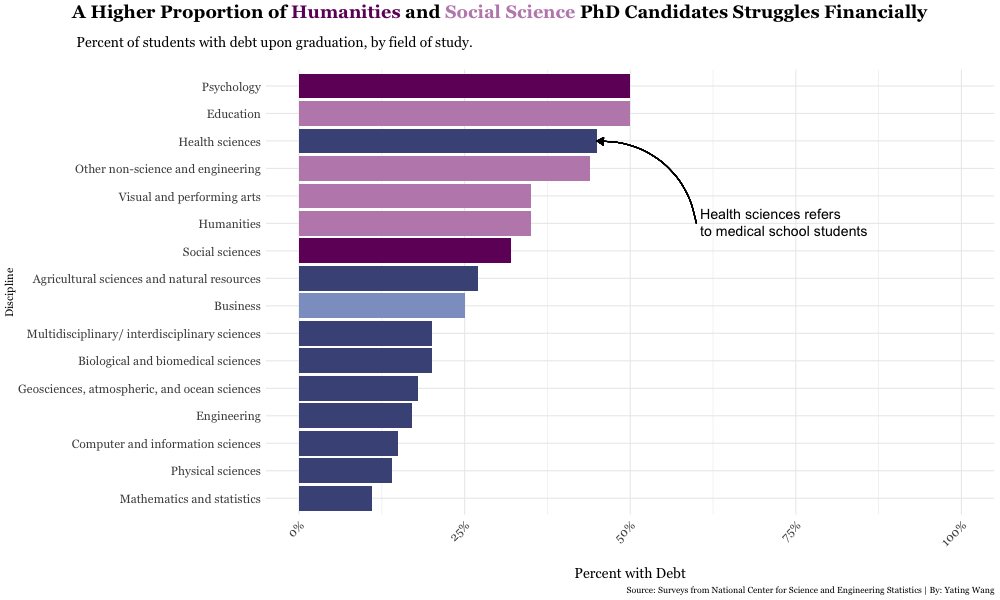

In [77]:
%%R -w 1000 -h 600

customized_colors <- c(
    "Hard-core Science" = "#485487",  
    "Non-Science" = "#bf8cb9",      
    "Business" = "#8da0cb",
    "Social Science" = "#711568"
)

barchart <- ggplot(data, aes(y = reorder(Major, Percent_debt), x = Percent_debt, fill = Field)) +
    geom_bar(stat = "identity") + 
    scale_fill_manual(values = customized_colors) + 

    scale_x_continuous(limits = c(0, 1), labels = scales::percent_format(accuracy = 1)) +  

    annotate("richtext", x = 0.60, y = "Humanities", 
             label = "Health sciences refers <br>to medical school students", 
             size = 5, color = "black", hjust = 0, fill = NA, label.color = NA) + 

    geom_curve(aes(x = 0.60, y = "Humanities", xend = 0.45, yend = "Health sciences"),  
               arrow = arrow(length = unit(0.1, "inches"), type = "closed"),  
               color = "black", curvature = 0.4, size = 0.5) + 

    labs(
    title = "A Higher Proportion of <span style='color:#711568;'>Humanities</span> and <span style='color:#bf8cb9;'>Social Science</span> PhD Candidates Struggles Financially",
    subtitle = "Percent of students with debt upon graduation, by field of study.",
    x = "Percent with Debt", y = "Discipline",
    caption = "Source: Surveys from National Center for Science and Engineering Statistics | By: Yating Wang"
) +  
theme_minimal() +
theme(
    text = element_text(family = "Georgia"),
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_markdown(size = 18, hjust = 0.5, face = "bold", margin = margin(b = 15)),  
    plot.subtitle = element_text(size = 14, hjust = 0.12, margin = margin(b = 20)),  
    axis.title.x = element_text(size = 14, margin = margin(t = 20)),  
    axis.text = element_text(size = 12),
    plot.title.position = "plot",
    plot.background = element_rect(fill = "white", color = NA), 
    panel.background = element_rect(fill = "white", color = NA),
    legend.position = "none"  # Drop the legend
)

barchart



In [78]:
%%R

ggsave("barchart.png", 
       plot = barchart,          
       width = 14, height = 8,     
       dpi = 300,                  
       units = "in")  

In [270]:
%%R

piv <- data %>%
    group_by(Field, Major) %>%
    summarise(count = sum(Count))

`summarise()` has grouped output by 'Field'. You can override using the
`.groups` argument.


# the header bg image showing the amount of enrollment across field of study

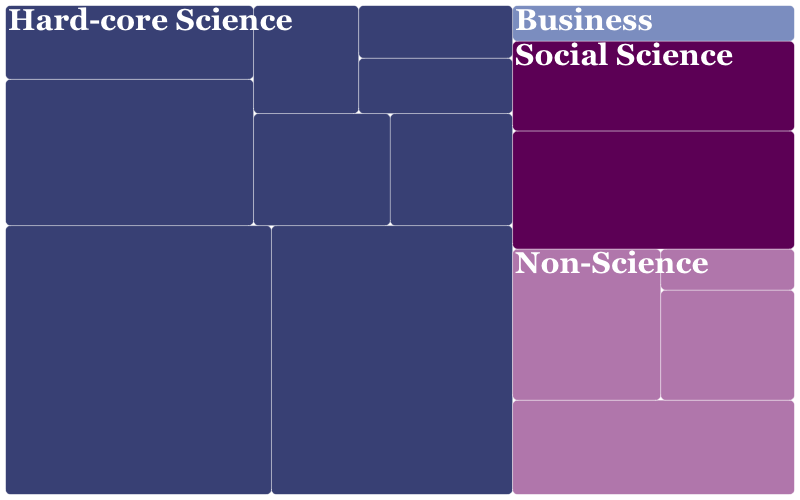

In [679]:
%%R -w 800 -h 500

library(ggplot2)
library(treemapify)


treemap <- ggplot(piv) +
  aes(area = count, fill = Field, label = Major, subgroup = Field) + 
  geom_treemap(color = "white", size = 0.5, radius = unit(5, "pt")) + 
  geom_treemap_subgroup_text(
    place = "topleft",  
    color = "white",       
    family = "Georgia", 
    fontface = "bold",
    size = 30
  ) + 
  scale_fill_manual(values = customized_colors) + 
  labs(
    #title = "Numbers of Doctoral Recipients in 2023 by Field of Study", 
    fill = "Field"
  ) + 
  theme_minimal() +
  theme(
    legend.position = "none",
    text = element_text(family = "Georgia"),
    plot.title = element_text(size = 18, hjust = 0.5),
    plot.background = element_rect(fill = "white", color = NA), 
    panel.background = element_rect(fill = "white", color = NA)  
  )

treemap


In [680]:
%%R

ggsave("treemap.png", 
       plot = treemap,          
       width = 10, height = 8,     
       dpi = 300,                  
       units = "in")   

# a scatterplot showing difference between private universities and public universities

In [509]:
private = pd.read_csv('private.csv')
private.drop('Year', axis=1, inplace=True)

private


,Institution,Amount (USD)
0,Columbia University,"$41,520"
1,Princeton University,"$35,416"
2,Stanford University,"$35,310"
3,Brown University,"$34,856"
4,Northwestern University,"$34,176"
5,University of Southern California,"$34,000"
6,Yale University,"$33,600"
7,Cornell University,"$33,484"
8,University of Pennsylvania,"$32,255"
9,Southern Methodist University,"$32,160"


In [535]:
private.to_csv('privater.csv', index=False)

In [543]:
%%R

private <- read_csv('privater.csv')

Rows: 33 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Institution, Amount (USD)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [544]:
%%R

private

# A tibble: 33 × 2
   Institution                       `Amount (USD)`
   <chr>                             <chr>         
 1 Columbia University               $41,520       
 2 Princeton University              $35,416       
 3 Stanford University               $35,310       
 4 Brown University                  $34,856       
 5 Northwestern University           $34,176       
 6 University of Southern California $34,000       
 7 Yale University                   $33,600       
 8 Cornell University                $33,484       
 9 University of Pennsylvania        $32,255       
10 Southern Methodist University     $32,160       
# ℹ 23 more rows
# ℹ Use `print(n = ...)` to see more rows


In [570]:
%%R


privater <- private %>%
  rename(`Amount_USD` = `Amount (USD)`) %>%
  mutate(
    `Amount_USD` = gsub(",", "", `Amount_USD`),   
    `Amount_USD` = gsub("\\$", "", `Amount_USD`), 
    `Amount_USD` = as.integer(`Amount_USD`)       
  ) 

privater

# A tibble: 33 × 2
   Institution                       Amount_USD
   <chr>                                  <int>
 1 Columbia University                    41520
 2 Princeton University                   35416
 3 Stanford University                    35310
 4 Brown University                       34856
 5 Northwestern University                34176
 6 University of Southern California      34000
 7 Yale University                        33600
 8 Cornell University                     33484
 9 University of Pennsylvania             32255
10 Southern Methodist University          32160
# ℹ 23 more rows
# ℹ Use `print(n = ...)` to see more rows


In [574]:
%%R

privater$school <- "private university"

In [575]:
%%R

privater

# A tibble: 33 × 3
   Institution                       Amount_USD school            
   <chr>                                  <int> <chr>             
 1 Columbia University                    41520 private university
 2 Princeton University                   35416 private university
 3 Stanford University                    35310 private university
 4 Brown University                       34856 private university
 5 Northwestern University                34176 private university
 6 University of Southern California      34000 private university
 7 Yale University                        33600 private university
 8 Cornell University                     33484 private university
 9 University of Pennsylvania             32255 private university
10 Southern Methodist University          32160 private university
# ℹ 23 more rows
# ℹ Use `print(n = ...)` to see more rows


In [555]:
%%R


public <- read_csv('public.csv')

Rows: 43 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Institution, Amount (USD), Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [561]:
%%R

public <- public %>%
select(-`Year`)

In [566]:
%%R


public_clean <- public %>%
  rename(`Amount_USD` = `Amount (USD)`) %>%
  mutate(
    `Amount_USD` = gsub(",", "", `Amount_USD`),   
    `Amount_USD` = gsub("\\$", "", `Amount_USD`), 
    `Amount_USD` = as.integer(`Amount_USD`)       
  )

Zusätzlich: Warnmeldung:
There was 1 warning in `mutate()`.
ℹ In argument: `Amount_USD = as.integer(Amount_USD)`.
Caused by warning:
! NAs durch Umwandlung erzeugt 


In [567]:
%%R

publicr <- na.omit(public_clean)

In [576]:
%%R

publicr$school <- "public university"

In [577]:
%%R

combined_data <- rbind(publicr, privater)

In [602]:
%%R

medians <- combined_data %>%
  group_by(school) %>%
  summarize(median_amount = median(Amount_USD))

medians

# A tibble: 2 × 2
  school             median_amount
  <chr>                      <dbl>
1 private university        29521 
2 public university         20808.


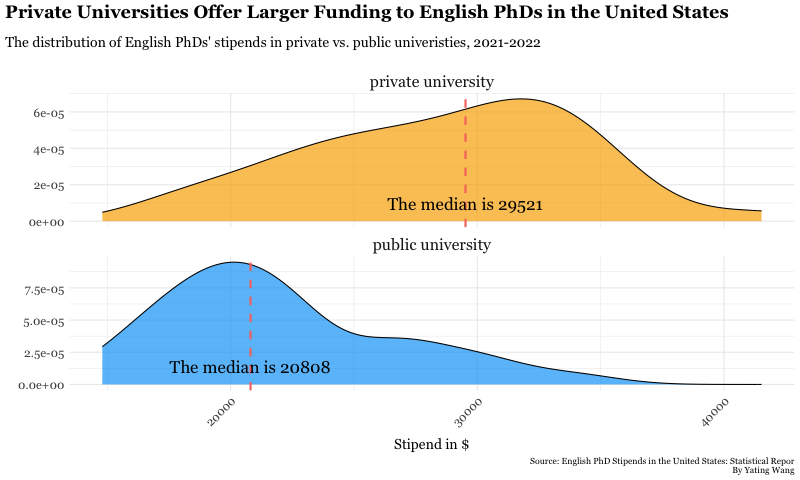

In [717]:
%%R -w 800

medians <- combined_data %>%
  group_by(school) %>%
  summarize(
    median_amount = median(Amount_USD),
    median_text = paste("The median is", round(median_amount)) 
  )


dist <- ggplot(combined_data) +
  aes(x = Amount_USD) + 
  geom_density(aes(fill = school), color = "black", alpha = 0.7) +  
  geom_vline(data = medians, aes(xintercept = median_amount, color = "black"), linetype = "dashed", size = 1) + 
  geom_text(data = medians, 
            aes(x = median_amount, y = 0, label = median_text), 
            color = "black", 
            vjust = -1, 
            size = 6,
            family = "Georgia") +  
  facet_wrap(~school, scales = "free_y", ncol = 1) + 
  scale_fill_manual(values = c("#f9ae01", "#01a6f9")) +  
  labs(
    title = "Private Universities Offer Larger Funding to English PhDs in the United States",
    subtitle = "The distribution of English PhDs' stipends in private vs. public univeristies, 2021-2022",
    x = "Stipend in $", y = "",
    caption = "Source: English PhD Stipends in the United States: Statistical Repor\nBy Yating Wang"
  ) +  
  theme_minimal() +
  theme(
    text = element_text(family = "Georgia"),
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 18, face = "bold", margin = margin(b = 15)),  
    plot.subtitle = element_text(size = 14, margin = margin(b = 20)),  
    axis.title.x = element_text(size = 14, margin = margin(t = 10)),  
    axis.text = element_text(size = 12), 
    legend.position = "none",
    plot.title.position = "plot",
    strip.text = element_text(size = 16),
    plot.background = element_rect(fill = "white", color = NA), 
    panel.background = element_rect(fill = "white", color = NA)  
  )

dist

In [719]:
%%R

ggsave("distribution.png", 
       plot = dist,          
       width = 12, height = 8,     
       dpi = 300,                  
       units = "in")   